In [13]:
# !pip install alpha_vantage
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
%config InlineBackend.figure_format='retina'

In [72]:
def stock_info(stock_symbol):
    data, meta_data = ts.get_daily(symbol=stock_symbol, outputsize='full')
    data['date'] = data.index
    data = data.reset_index(drop=True)
    df1 = data[:len(data[data['date'] >' 2020-02-11'])+1]
    percent = round((df1['4. close'].iloc[0]/df1['4. close'].iloc[-1]-1)*100,2)
    print(f'Percent down since COVID-19 market crash (February 12 2020) = {percent}%')
    print('')
    print('Below is how the stock was doing 6 months prior:')

    mask1 = data['date'] >= '2019-08-12'
    mask2 = data['date'] <= '2020-02-12'

    dff = data[mask1 & mask2]

    plt.plot(dff['date'],dff['4. close'])
    plt.tight_layout()
    plt.grid()
    return plt.show()
    
    
    

    

Percent down since COVID-19 market crash (February 12 2020) = -18.83%

Below is how the stock was doing 6 months prior:


{'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2020-04-07', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


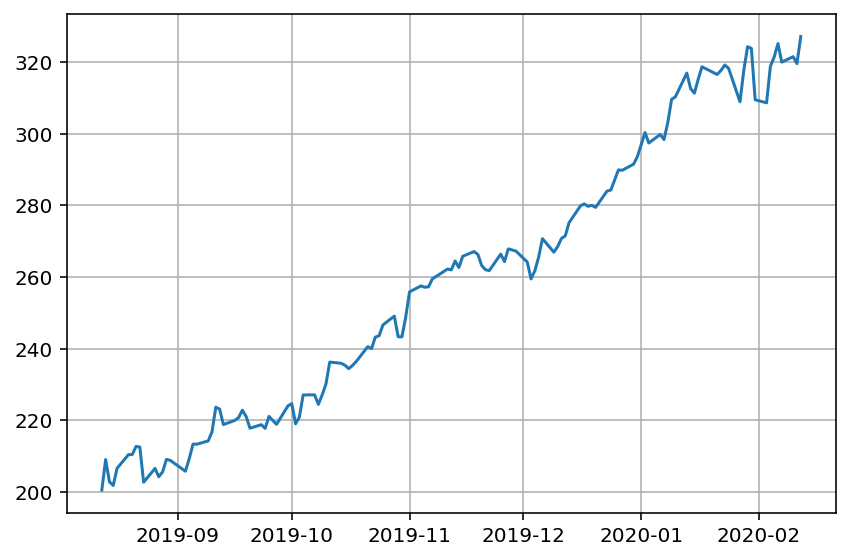

In [71]:
stock_info('AAPL')